In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Decision Diagrams

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

In [ ]:
from stringdale.diagrams import (
    Define,
    V,
    E,
)

## Different types of diagrams

The type of diagrams we have seen so far are called flow diagrams.
In Flow diagrams:

* There are no cycles
* All nodes run based on the output

Another Type of Diagrams are Decision Diagrams.
In Decision diagrams:
* You can have cycles
* After Each Node, we need to choose the next node to run based on a condition function.

Flow diagrams are the default type but we can also define them explicitly.

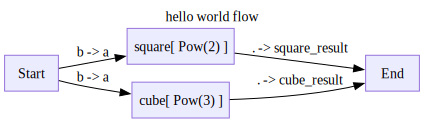

Node square:
{'input': {'a': 2}, 'output': 4}
Node cube:
{'input': {'a': 2}, 'output': 8}


{'square_result': 4, 'cube_result': 8}

In [ ]:
with Define('hello world flow',type='flow',direction='LR') as D:
    V('square',Pow(2),inputs=['Start(a=b)'],outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output

Decision diagrams can be defined in a similar manner

In [ ]:
def is_b_even(obj):
    return obj['b']%2==0

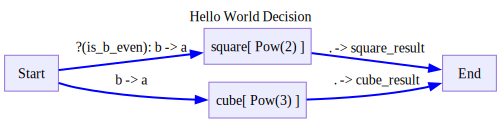

In [ ]:
with Define('Hello World Decision',type='decision',direction='LR') as D:
    V('square',Pow(2),outputs=['End(square_result=.)'])
    V('cube',Pow(3),outputs=['End(cube_result=.)'])
    # we define conditional edges by adding a cond argument to the edge
    E('Start->square(a=b)',cond=is_b_even)
    # each non-end node must have at least one edge with no condition, the default edge
    E('Start->cube(a=b)')


We can also inline conditional edge definition in the node definition by providing a tuple of the form `(edge_string,cond)` to the `inputs` or `outputs` keys.

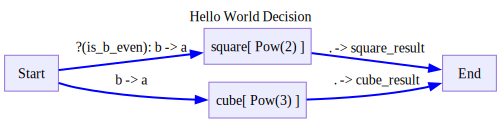

In [ ]:
with Define('Hello World Decision',type='decision',direction='LR') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])


Unlike in our flow example, here either square or cube is called, but not both.

In [ ]:
d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4}

In [ ]:
d=D()
for trace in d.run({'a':1,'b':3}):
    trace.pprint(skip_passthrough=True)
d.output

Node cube:
{'input': {'a': 3}, 'output': 27}


{'cube_result': 27}

## Conditions made easier

Having to write funciton like checking if the key `b` is even can get out of hand pretty fast.

To avoid having to write alot of small condition functions for different object configurations,
stringdale's standard library has a `Condition` class that gives you the power of port mapping in your conditions.

In [ ]:
from stringdale.std import Condition

In [ ]:
is_even = lambda x: x%2==0
smaller_than_5 = lambda x: x<5

is_b_even = Condition(is_even,mapping='x=b',name='is_b_even')

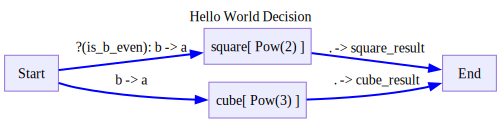

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4}

In [ ]:
with Define('Hello World Decision',type='decision',direction='LR') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output

`Condition` has a bunch of other nice utilities, such as the ability to combine conditons via `and` or `or`

In [ ]:
b_smaller_than_5 = Condition(smaller_than_5,mapping='x=b',name='b_smaller_than_5')

even_but_not_too_big = is_b_even & b_smaller_than_5
even_but_not_too_big

(is_b_even & b_smaller_than_5)

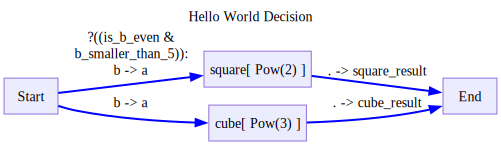

In [ ]:
with Define('Hello World Decision',type='decision',direction='LR') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',even_but_not_too_big),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])


In [ ]:
d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4}

In [ ]:
d=D()
for trace in d.run({'a':1,'b':10}):
    trace.pprint(skip_passthrough=True)
d.output

Node cube:
{'input': {'a': 10}, 'output': 1000}


{'cube_result': 1000}

You can find out more about `Condition` and other utilities in the `Standard Library Nodes` Section.

## Introduce Diagram State

Often, we would like to use state from previous nodes.
In flow diagrams, we can simply connect them, but in decision diagrams, this can make the diagram not well defined.

To solve this problem, stringdale has support for diagram states.

Here is a basic example of it:

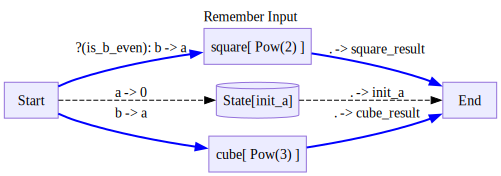

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4, 'init_a': 1}

In [ ]:
with Define('Remember Input',type='decision',direction='LR') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

    # We can write and read from the state using nodes of the from 'State/key'
    # State nodes are special nodes that are not part of the execution, but are used to store information.
    E('Start->State/init_a(0=a)')
    V('End',inputs=['State/init_a(init_a=.)'])

d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output


If we dont supply a node that writes to a State, we can supply the state manually when running the diagram

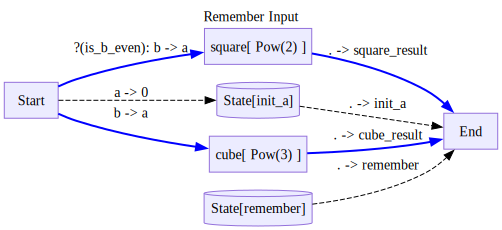

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4, 'init_a': 1, 'remember': 100}

In [ ]:
with Define('Remember Input',type='decision',direction='LR') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

    E('Start->State/init_a(0=a)')
    V('End',inputs=['State/init_a(init_a=.)'])
    V('End',inputs=['State/remember(remember=.)'])

d=D()
for trace in d.run({'a':1,'b':2},state={'remember':100}):
    trace.pprint(skip_passthrough=True)
d.output


Diagram State is a very powerful feature of stringdale. To learn more about the power of state, see the customizing state section.

## Breakpoint - interactive Diagrams 

Getting feedback from the user mid flow can lead to very powerful agents.
To enable this in stringdale, we can have breakpoint like nodes in Decision Diagrams.
They can be defined like so:

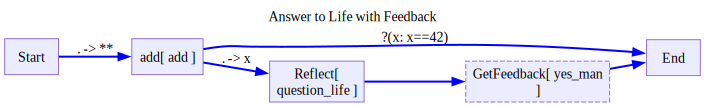

In [ ]:
is_42 = lambda x: x==42
def question_life(x):
    return f'is {x} really the answer?'

def yes_man(message):
    return f'Yes man, {message}'

with Define('Answer to Life with Feedback',type='decision',direction='LR') as D:
    V('add',add,
        inputs=['Start(**)'],
        outputs=[
            ('End',is_42),
            'Reflect(x=.)'
        ])
    # we mark a node as a breakpoint via the is_break flag
    V('Reflect',question_life,outputs=['GetFeedback'])
    V('GetFeedback',yes_man,is_break=True,
        outputs=['End']
    )    



When we run a diagram, we actually run it either to the End, or the first breakpoint we encounter.
We can check this via the `finished` attribute of the diagram.

In [ ]:
d1=D()
for trace in d1.run({'a':20,'b':22}):
    trace.pprint(skip_passthrough=True)

d1.finished,d1.output

Node add:
{'input': {'a': 20, 'b': 22}, 'output': 42}


(True, 42)

In [ ]:
d2=D()
for trace in d2.run({'a':20,'b':21}):
    trace.pprint(skip_passthrough=True)

d2.finished,d2.output

Node add:
{'input': {'a': 20, 'b': 21}, 'output': 41}
Node Reflect:
{'input': {'x': 41}, 'output': 'is 41 really the answer?'}


(False, 'is 41 really the answer?')

running an unfinished diagram again will cause it to continue, while running a finished diagram again will cause it to restart.

In [ ]:
for trace in d2.run('43 is fine too'):
    trace.pprint(skip_passthrough=True)

d2.finished,d2.output

Node GetFeedback:
{'input': {0: '43 is fine too'}, 'output': 'Yes man, 43 is fine too'}


(True, 'Yes man, 43 is fine too')

In [ ]:
for trace in d1.run({'a':7,'b':35}):
    trace.pprint(skip_passthrough=True)

d1.finished,d1.output

Node add:
{'input': {'a': 7, 'b': 35}, 'output': 42}


(True, 42)

We can use this pattern to communicate with the user in a stateful way.

Lets define a mock client, in practice, this will be your app's logic

In [ ]:
class Client:
    def __init__(self,user_messages):
        self.msg_queue = user_messages
    def end_of_conversation(self):
        return len(self.msg_queue)==0
    def get_next_user_input(self):
        next_msg = self.msg_queue.pop(0)
        print(f'User: {next_msg}')
        return next_msg
    def send_answer(self,answer):
        print(f'Assistant: {answer}')
    def new_topic(self):
        print('='*100)


        

In [ ]:
user_messages = [
    {'a':20,'b':22},
    {'a':20,'b':23},
    f'43 is fine too',
    {'a':7,'b':35}
]
client = Client(user_messages)

d=D()
while not client.end_of_conversation():
    next_input = client.get_next_user_input()
    for trace in d.run(next_input):
        pass
    client.send_answer(d.output)
    if d.finished:
        client.new_topic()

User: {'a': 20, 'b': 22}
Assistant: 42
User: {'a': 20, 'b': 23}
Assistant: is 43 really the answer?
User: 43 is fine too
Assistant: Yes man, 43 is fine too
User: {'a': 7, 'b': 35}
Assistant: 42
